In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

from IPython import display
display.set_matplotlib_formats('svg')


/home/edyalenquer-wsl/anaconda3/envs/dl_studies/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/edyalenquer-wsl/anaconda3/envs/dl_studies/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/tmp/ipykernel_8169/89904320.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
MNIST = torchvision.datasets.MNIST(".", download=True)

In [3]:
train_data = MNIST.train_data
train_labels = MNIST.train_labels
test_data = MNIST.test_data
test_labels = MNIST.test_labels

/home/edyalenquer-wsl/anaconda3/envs/dl_studies/lib/python3.8/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/edyalenquer-wsl/anaconda3/envs/dl_studies/lib/python3.8/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/edyalenquer-wsl/anaconda3/envs/dl_studies/lib/python3.8/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/edyalenquer-wsl/anaconda3/envs/dl_studies/lib/python3.8/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


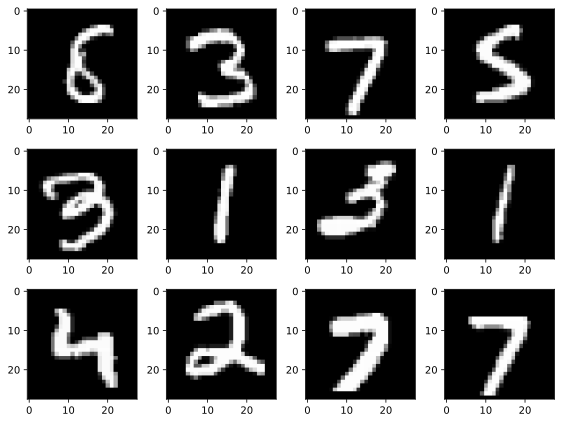

In [4]:
fig, ax_list = plt.subplots(3, 4, figsize=(8, 5))

for ax in ax_list.flatten():

    idx = np.random.choice(train_data.shape[0])
    img = train_data[idx]

    ax.imshow(img, cmap='gray')

plt.tight_layout(rect=[0,0,1,1.2])
plt.show()


In [5]:
train_data = train_data / train_data.max()
test_data = test_data / train_data.max()

In [6]:

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

In [7]:
BATCH_SIZE = 32

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [25]:
class MNIST_Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.input_layer = nn.Linear(784, 64)
        self.hidden_layer_1 = nn.Linear(64, 32)
        self.hidden_layer_2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 10)

    def forward(self, X):
        X = F.relu(self.input_layer(torch.flatten(X, start_dim=1)))
        X = F.relu(self.hidden_layer_1(X))
        X = F.relu(self.hidden_layer_2(X))
        output = torch.log_softmax(self.output_layer(X), axis=1)
        
        return output

model = MNIST_Net()
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01)


In [26]:
N_EPOCHS = 60

epoch_loss, epoch_accuracy = [], []
test_accuracy = []
for i in range(N_EPOCHS):

    batch_loss, batch_accuracy = [], []
    for X, y in train_loader:

        y_pred = model(X)
        loss = loss_function(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_loss.append(loss.item())

        correct_examples = torch.argmax(y_pred, axis=1) == y
        correct_examples = correct_examples.float()  # to calculate the mean
        accuracy = torch.mean(correct_examples)
        batch_accuracy.append(accuracy.item())

    epoch_loss.append(np.mean(batch_loss))
    epoch_accuracy.append(np.mean(batch_accuracy))


    X_test, y_test = next(iter(test_loader))
    y_test_pred = model(X_test)

    correct_test_examples = torch.argmax(y_test_pred, axis=1) == y_test
    accuracy = torch.mean(correct_test_examples.float())
    test_accuracy.append(accuracy.item())


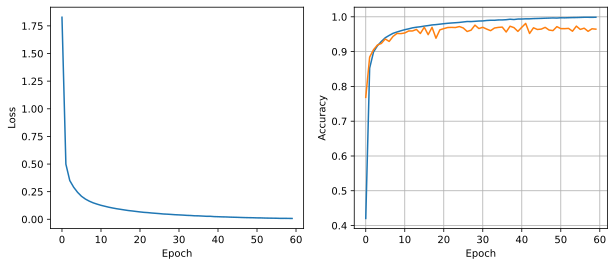

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(epoch_loss)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')

ax[1].plot(epoch_accuracy, label='Train')
ax[1].plot(test_accuracy, label='Test')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

plt.grid(True)

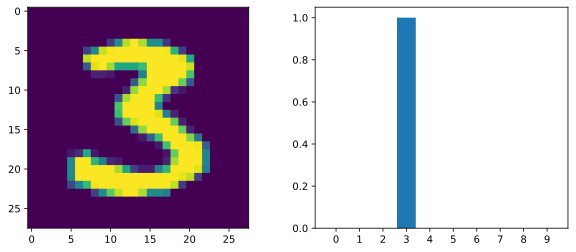

In [47]:
X_test, y_test = next(iter(test_loader))
y_test_pred = model(X_test).detach()


idx = 874

# plt.imshow(X_test[idx])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].imshow(X_test[idx])

ax[1].bar(range(10), np.exp(y_test_pred[idx]))
ax[1].set_xticks(range(10))

plt.show()